## Train an image classifier using a pre-trained model using PyTorch

In [1]:
import os
import cv2
import torch
import torchvision

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pytesseract

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

/Users/nixi/Desktop/AI-4-Media-23-24/.conda/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nixi/Desktop/AI-4-Media-23-24/.conda/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c1017RegisterOperatorsD1Ev)
  Referenced from: '/Users/nixi/Desktop/AI-4-Media-23-24/.conda/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/nixi/Desktop/AI-4-Media-23-24/.conda/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/nixi/Desktop/AI-4-Media-23-24/.conda/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch

#####  Define Hyperparameters
( label each emotional state)

In [2]:
device = 'cpu'
momentum = 0.9
num_epochs = 10
num_classes = 3
val_size = 0.3
batch_size = 100
learn_rate = 0.001
freeze_lower_layers = True
data_path = '//Users/nixi/Desktop/-Artificial-Intelligence-for-Media-23-24-project/main/Main-project-images/my-classification-dataset'

In [3]:
# Double check my class datasets are recognised
os.listdir('/Users/nixi/Desktop/-Artificial-Intelligence-for-Media-23-24-project/main/Main-project-images/my-classification-dataset')

['neutral-face',
 'happy-face',
 '.DS_Store',
 'surprised-face',
 'sad-face',
 'angry-face',
 'scared-face',
 'disgusted-face']

#### Isolating faces from images ( particularly for magazine data and to remove solely text data thta may have been collected during sampling)
- I could exclude images with text using a text detector, but this may reduce the dataset significantly.
- Use Haar Cascade classifier ( which uses feature based object detection) available from https://github.com/opencv/opencv/tree/4.x/data/haarcascades
- The following code shows the implementation of four different methods to fix my data accordingly ( face focus, no text)

## Continue debugging here


In [10]:
# Code adapted from: https://www.geeksforgeeks.org/reading-image-opencv-using-python/?ref=lbp 
# POSSIBLE THAT THIS CODE IS NOT WORKING PROPERLY TO REMOVE TEXT BEFORE PLOTTING THE TRAINING AND VALIDATION IMAGES
# Haar was not dowloaded and implemented properly! 

# Haar Cascade Classifier for face detection :
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalcatface_extended.xml')

# Path to the directory containing your images
directory_path = '/Users/nixi/Desktop/-Artificial-Intelligence-for-Media-23-24-project/main/Main-project-images/my-classification-dataset'

# Iterate over all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load the image
        image = cv2.imread(os.path.join(directory_path, filename))
        
        # Convert the image to grayscale for text detection and face detection
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Perform OCR and extract text
        text = pytesseract.image_to_string(gray)
        
        # Check if text is present in the image
        if len(text.strip()) > 0:
            # If text is detected, you can choose to skip or process the image further
            continue
        
        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        # Draw rectangles around the detected faces
        for (x, y, w, h) in faces:
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Display the image with detected faces
        cv2.imshow('Faces Detected', image)
        cv2.waitKey(0)

cv2.destroyAllWindows()

In [11]:
!cd /Users/nixi/Desktop/-Artificial-Intelligence-for-Media-23-24-project/main/Main-project-images/my-classification-dataset

In [12]:
%pip install pytesseract pillow

Note: you may need to restart the kernel to use updated packages.


In [15]:
import cv2
import os
import pytesseract
from pytesseract import Output
from PIL import Image

# Haar Cascade Classifier for face detection 
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalcatface_extended.xml')

# Path to the directory containing images
directory_path = '/Users/nixi/Desktop/-Artificial-Intelligence-for-Media-23-24-project/main/Main-project-images/my-classification-dataset'


# Take into account that the images may not be printing becasue my data is seperated into 7 different classes
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'  

# Iterate over all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        try:
            # Load the image
            image = cv2.imread(os.path.join(directory_path, filename))
            # exception handling in case the script could not load the image
            if image is None:
                print(f'Could not open or find the image: {filename}')
                continue

            # Convert the image to grayscale for text detection and face detection
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Perform OCR and extract text
            d = pytesseract.image_to_string(gray, config='--psm 6', output_type=Output.DICT)
    
            # Remove the text by blacking out using pytessaract's bounding box coordinates
            if len(d['text']):
                n_boxes = len(d['level'])
                for i in range(n_boxes):
                    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 0), -1)
            
            # Detect faces in the image
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # Draw rectangles around the detected faces
            if len(faces):
                for (x, y, w, h) in faces:
                    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

            # Display the image
            cv2.imshow('Faces Detected', image)
            cv2.waitKey(0)
        except Exception as e:
            print(f'Error processing {filename} : {str(e)}')

cv2.destroyAllWindows()

In [14]:
import cv2
import os
import pytesseract
from pytesseract import Output

# Haar Cascade Classifier for face detection 
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalcatface_extended.xml')

# Paths to the directories containing your images and to save the processed images
#directory_path = 'Main-project-images/my-data/my-classification-dataset'
processed_directory_path = '/Users/nixi/Desktop/-Artificial-Intelligence-for-Media-23-24-project/main/Main-project-images/my-classification-dataset'
os.makedirs(processed_directory_path, exist_ok=True)

pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'  

# Standard size to resize the images of faces
standard_size = (224, 224)

# Iterate over all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load the image
        image = cv2.imread(os.path.join(directory_path, filename))
        
        # Convert the image to grayscale for text detection and face detection
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Perform OCR and extract text
        d = pytesseract.image_to_string(gray, config='--psm 6', output_type=Output.DICT)
        
        # Remove the text by blacking out using pytessaract's bounding box coordinates
        if len(d['text']):
            n_boxes = len(d['level'])
            for i in range(n_boxes):
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 0), -1)
        
        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Draw rectangles around the detected faces
        # If no faces are found, continue to the next image
        if len(faces) == 0:
            continue

        for (x, y, w, h) in faces:
            # Crop and resize the face area
            face_img = image[y:y+h, x:x+w]
            resized_face_img = cv2.resize(face_img, standard_size)
            
            # Save the processed image in the new directory
            cv2.imwrite(os.path.join(processed_directory_path, filename), resized_face_img)

print("Processing completed.")

Processing completed.


In [17]:
# Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalcatface_extended.xml')

# Path to the directory containing your images 
# ERROR HERE WITH FILE DIRECTORY PATHS

processed_directory_path = 'my-processed-dataset'

# Create the processed directory if it doesn't exist
os.makedirs(processed_directory_path, exist_ok=True)

# Iterate over all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load the image
        image = cv2.imread(os.path.join(directory_path, filename))
        
        # Convert the image to grayscale for text detection and face detection
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Perform OCR and extract text
        text = pytesseract.image_to_string(gray)
        
        # Check if text is present in the image
        if len(text.strip()) > 0:
            # If text is detected, you can choose to skip or process the image further
            continue
        
        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        # Draw rectangles around the detected faces
        for (x, y, w, h) in faces:
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Save the processed image in the new directory
        cv2.imwrite(os.path.join(processed_directory_path, filename), image)

print("Processing completed. Processed images saved in 'my-processed-dataset'.")

Processing completed. Processed images saved in 'my-processed-dataset'.


In [18]:
# Does the new file exist?
!cd /Users/nixi/Desktop/-Artificial-Intelligence-for-Media-23-24-project/main/Main-project-images/my-processed-dataset

In [19]:
# Return any image in my preprocessed data... none found !
os.listdir('/Users/nixi/Desktop/-Artificial-Intelligence-for-Media-23-24-project/main/Main-project-images/my-processed-dataset') 

[]

##### Training image transforms and data augmentation 


In [63]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=(-30,30),translate=(0.15,0.15),scale=(0.85,1.15)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

##### Define Validation image transforms


In [64]:
val_transform = transforms.Compose(
    [   
        torchvision.transforms.Resize(224, antialias=True),
        torchvision.transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

##### Create datasets


In [66]:
# Instatiate train and validation dataset with seperate transforms
train_dataset = ImageFolder(data_path, transform=train_transform)
val_dataset = ImageFolder(data_path, transform=val_transform)

# Get length of dataset and indicies
num_train = len(train_dataset)
indices = list(range(num_train))

# Get train / val split for data points
train_indices, val_indices = train_test_split(indices, test_size=val_size, random_state=42)

# Override dataset classes to only be samples for each split
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

##### Plot training images

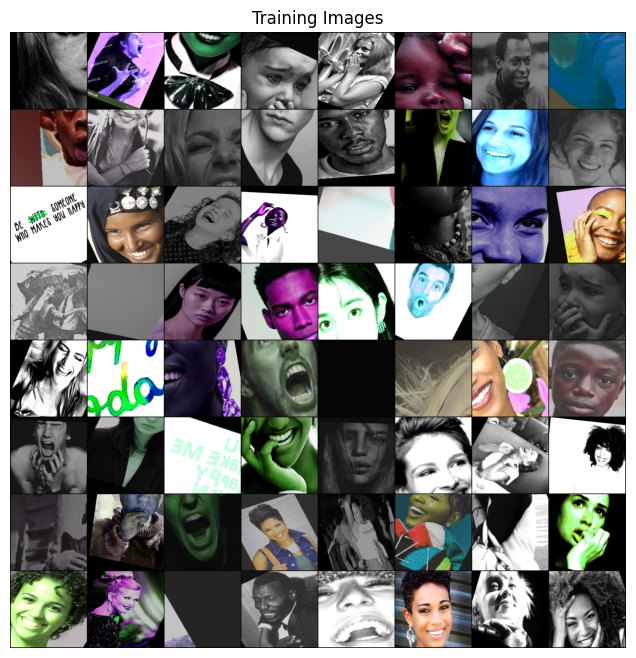

In [60]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

##### Plot validation set images

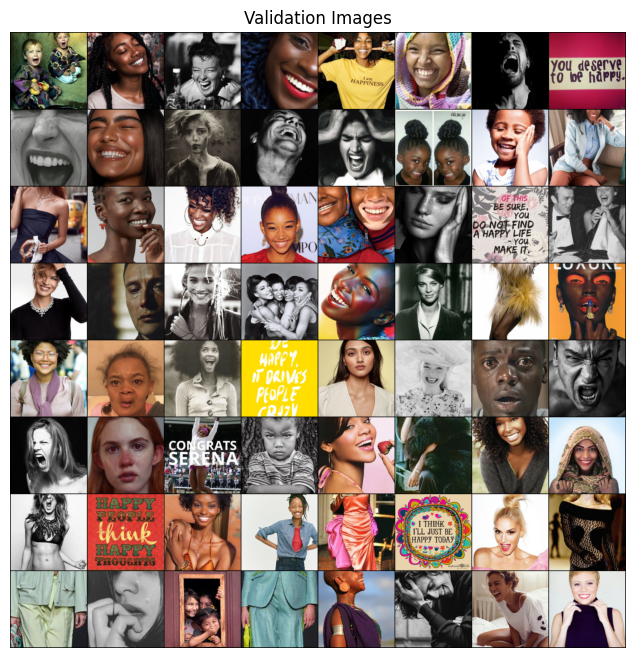

In [61]:
real_batch = next(iter(val_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Validation Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

#### Load pre-trained model
Used VisionTransformer ( within torchvision model library)  as opposed to creating my own convolution neural network from scratch. This differes from class code as ResNetwas used.

Code adapted from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [51]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define your device (e.g., CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model with pretrained weights
model = models.vision_transformer.VisionTransformer(weights='imagenet1k_v1').to(device)

# Freeze lower layers if needed
if freeze_lower_layers:
    for param in model.parameters():
        param.requires_grad = False

# Modify the final fully connected layer for your task
num_classes = 7 # number of classes for emotion detection
num_ftrs = model.head.in_features  # Assuming the last layer is named 'head' in this model
model.head = nn.Linear(num_ftrs, num_classes).to(device)

TypeError: __init__() got an unexpected keyword argument 'weights'

##### Setup loss and optimiser

In [ ]:
# Cross entropy loss for training classification
criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent loss
optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)

##### Training loop

Here is our training loop for our data. Just like the other notebook, look at how the training dataset and validation dataset are used? 

What differences are there in the code when we cycle through each of these sets of data?

In [ ]:
train_losses = []
val_losses = []

best_loss = 100000
for epoch in range(num_epochs): 
    train_loss = 0.0
    
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Get data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Process data
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Update model weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    
    # Validation loop
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    # Normalise cumulative losses to dataset size
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    
    # Added cumulative losses to lists for later display
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}')
    
    # if validation score is lowest so far, save the model
    # conditional statement, only saving the models that have a validation loss smaller than the previous.
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_finetuned_model.pt')

Epoch 1, train loss: 0.766, val loss: 0.678
Epoch 2, train loss: 0.759, val loss: 0.666
Epoch 3, train loss: 0.730, val loss: 0.658
Epoch 4, train loss: 0.739, val loss: 0.651
Epoch 5, train loss: 0.716, val loss: 0.647
Epoch 6, train loss: 0.722, val loss: 0.647


KeyboardInterrupt: 

##### Plot training vs validation loss 

